In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import shap

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")

# Data Exploration

## Category Encoder and Decoder

In [3]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [4]:
le_make_train = target_encoder(train_df)
le_make_control = target_encoder(control_df)

## MatPlots

In [5]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [6]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [7]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [8]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [9]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue="Transition_code"):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [10]:
def show_catplot(df, x_label, y_label, title="catplot", hue="Transition_code"):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [11]:
def show_pairplot(df,hue="Transition_code"):
    sns.pairplot(df,hue=hue)
    plt.show()

## Basic Exploration

In [12]:
def main_exploration(df):
    print(df.shape) 

In [13]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())

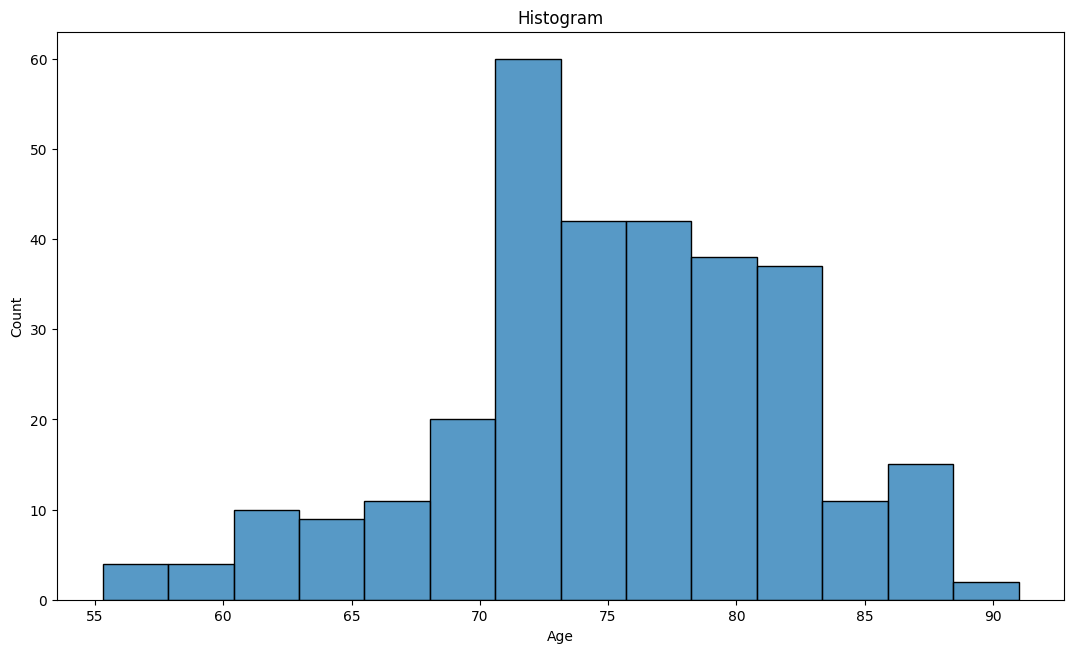

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


In [14]:
numerical_exploration(train_df)

In [15]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())

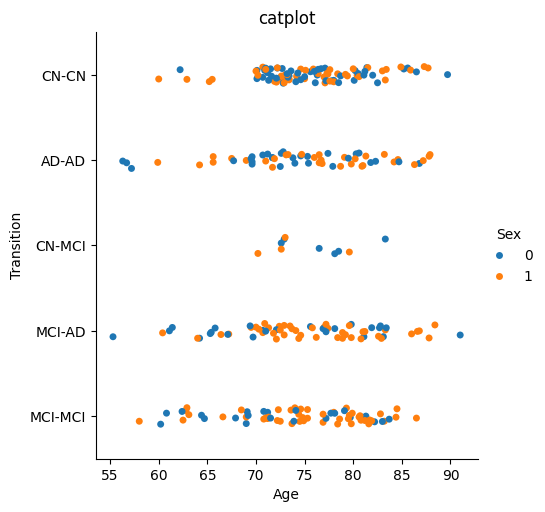

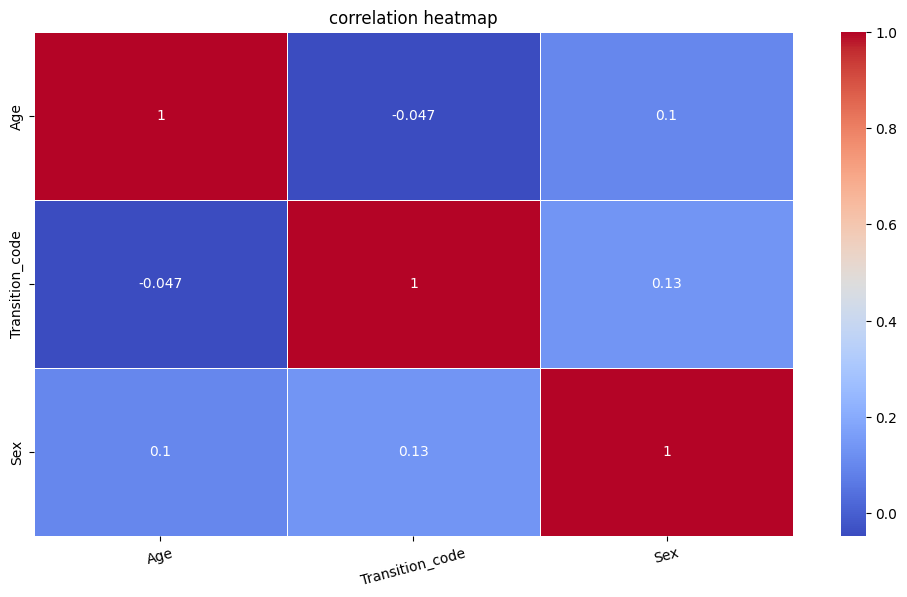

In [16]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

<Axes: >

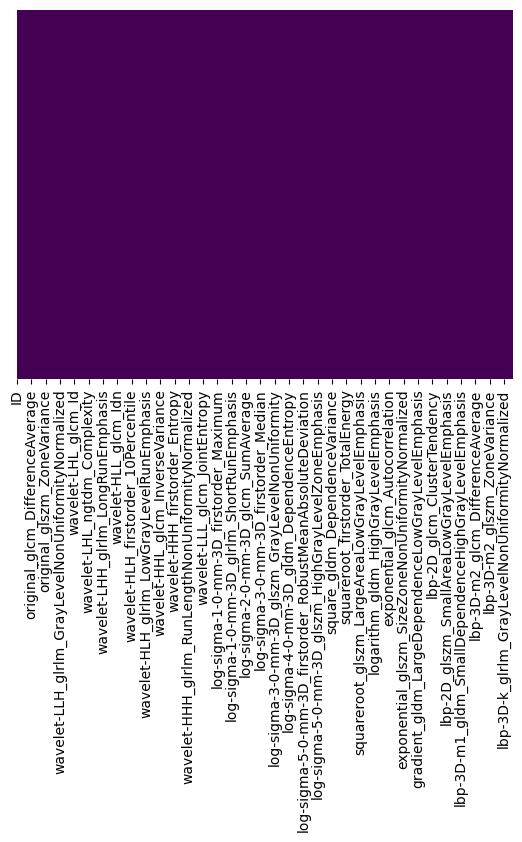

In [17]:
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [18]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [19]:
diagnostics_configs(train_df)

1
1


In [20]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [21]:
diagnostics_versions_explorer(train_df)

diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']


In [22]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 

In [23]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]

In [24]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex']

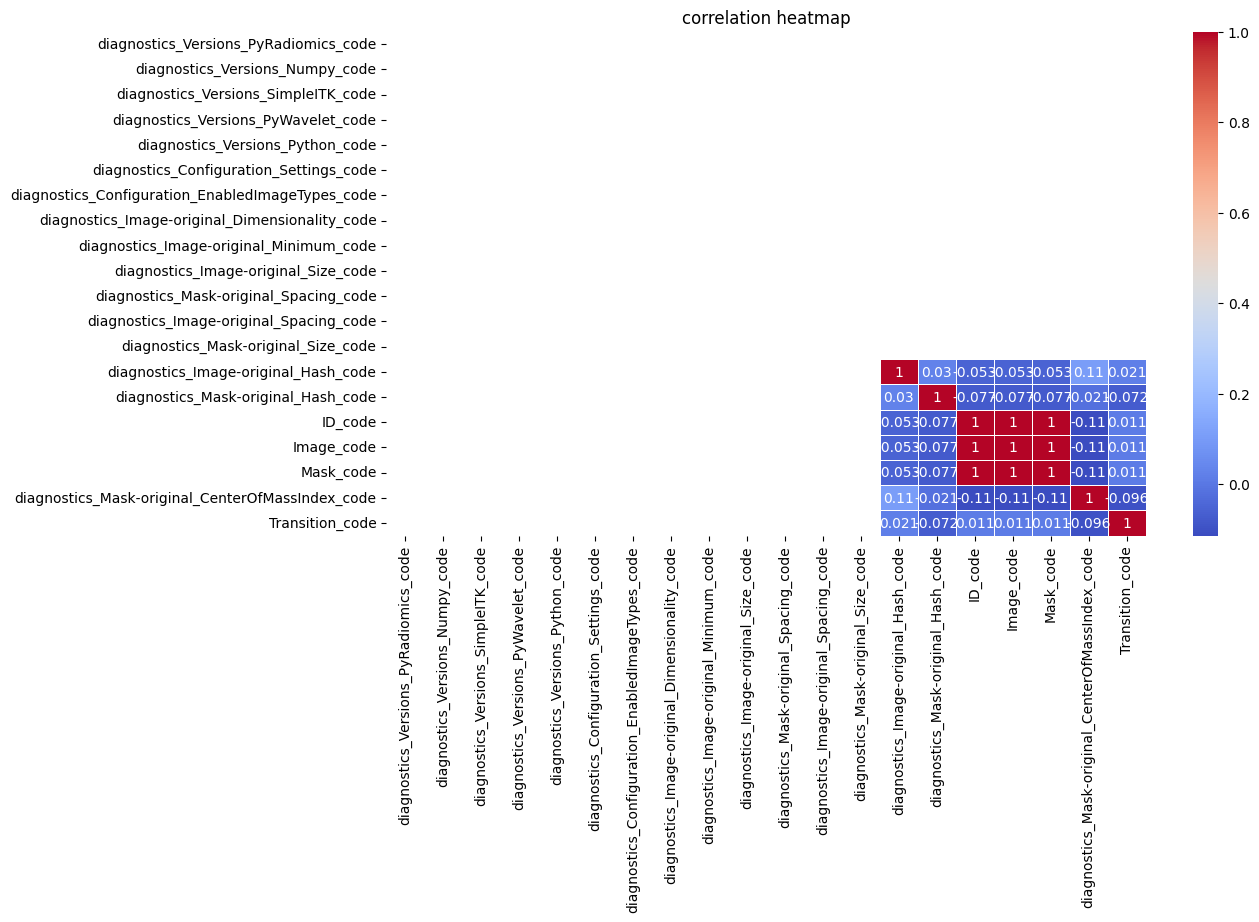

In [25]:
unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

## Correlations

In [26]:
def top_correlations(df, target="Transition_code",starts_with=None,number=10,ascending=False):
    if starts_with == None:
        corr_columns = df.select_dtypes(include=["int64","float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]

    corr_matrix = df[corr_columns].corrwith(df[target])

    top_features = corr_matrix.sort_values(ascending=ascending).head(number).index.tolist()
    top_features.append(target)
    top_features = pd.Index(top_features)
    
    return top_features

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


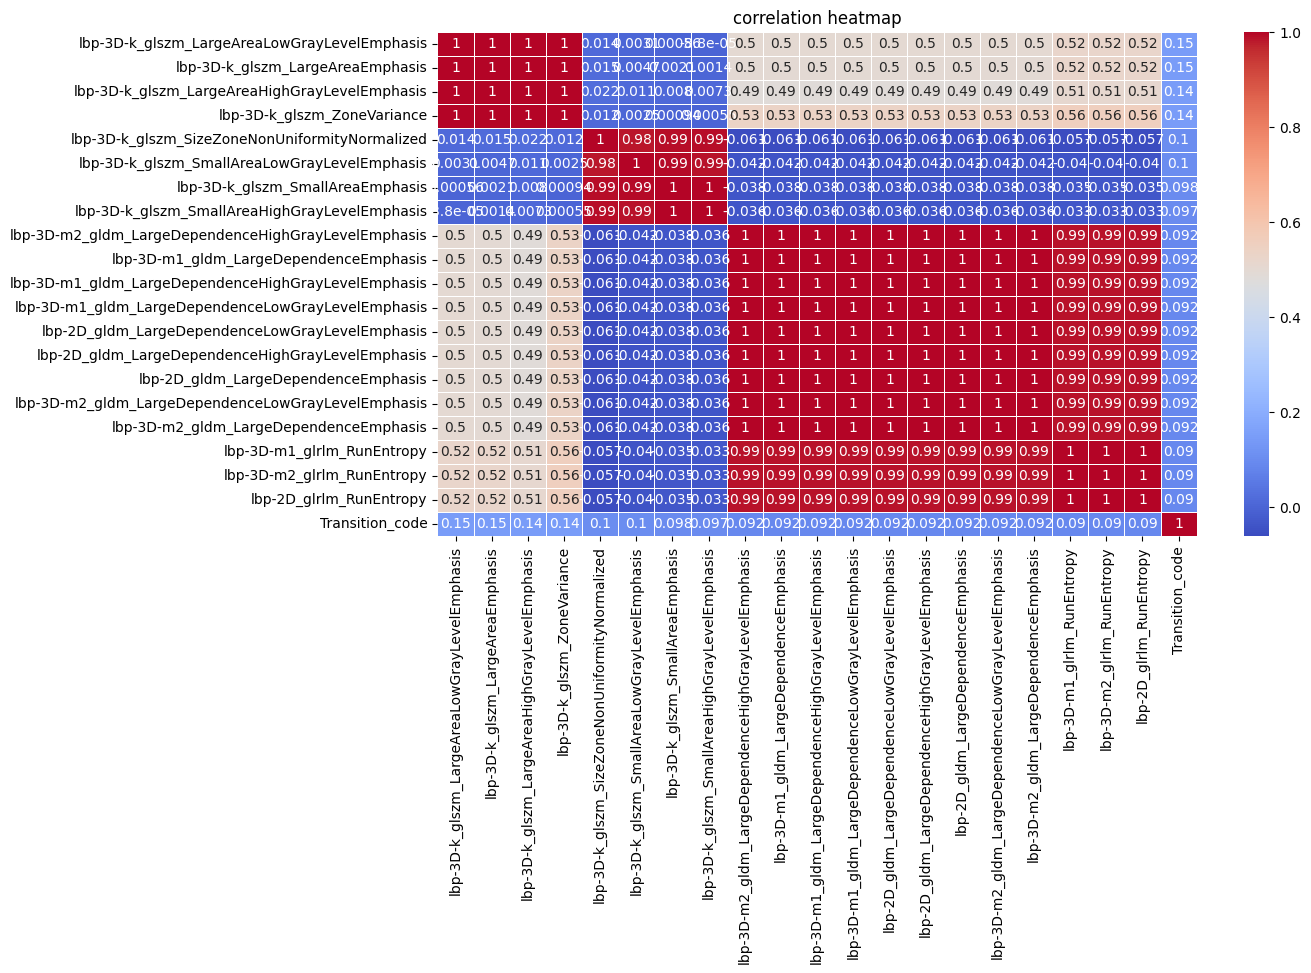

In [27]:
rad_corr = top_correlations(train_df,starts_with="lbp",number=20)
show_heatmap(train_df[rad_corr])

# Data Processing

## Drop Unnecessary Columns

In [28]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

## Nunique Columns

In [29]:
nunique_columns = train_df.columns[train_df.nunique() == 1].tolist()
train_df = train_df.drop(columns=nunique_columns, errors="ignore")
test_df = test_df.drop(columns=nunique_columns, errors="ignore")
control_df = control_df.drop(columns=nunique_columns, errors="ignore")

## Non Numerical Columns

In [30]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)


# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [31]:
# Separar a coluna de BoundingBox em várias colunas
test_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = test_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)


# Separar a coluna de CenterOfMassIndex em várias colunas
test_df[['x_center', 'y_center', 'z_center']] = test_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [32]:
# Separar a coluna de BoundingBox em várias colunas
control_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = control_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)


# Separar a coluna de CenterOfMassIndex em várias colunas
control_df[['x_center', 'y_center', 'z_center']] = control_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [33]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
test_df = test_df.drop(['diagnostaics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
control_df = control_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

In [34]:
main_exploration(train_df)

(305, 2024)


In [35]:
train_df = train_df.select_dtypes(include=['number'])
control_df = control_df.select_dtypes(include=['number'])
test_df = test_df.select_dtypes(include=['number'])

## Data Scaler

In [36]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(scaler_df),columns=scaler_df.columns)
    return df_scaled


In [37]:
scaled_train_df = data_scaler(train_df)
scaled_control_df = data_scaler(control_df)
scaled_test_df = data_scaler(test_df)

scaled_train_df["Transition_code"] = train_df["Transition_code"].values
scaled_control_df["Transition_code"] = train_df["Transition_code"].values

## Correlation Analisys

In [38]:
corr_df = scaled_train_df.copy()
corr_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
target = "Transition_code"

In [39]:
corr_threshold = 0
def apply_correlation(df,threshold):
    df = df.drop(columns=["Transition"],errors="ignore")
    correlation = df.corr()[target].abs().sort_values(ascending=False)
    important_features = correlation[correlation > threshold].index.tolist()
    
    if target in important_features:
        important_features.remove(target)

    return important_features

In [40]:
important_features = apply_correlation(scaled_train_df, corr_threshold)

In [41]:
corr_train_df = scaled_train_df[important_features]
corr_control_df = scaled_control_df[important_features]
corr_test_df = scaled_test_df[important_features]

In [42]:
corr_train_df["Transition_code"] = train_df["Transition_code"].values
corr_control_df["Transition_code"] = train_df["Transition_code"].values

In [43]:
main_exploration(corr_train_df)
main_exploration(corr_control_df)
main_exploration(corr_test_df)

(305, 2023)
(305, 2023)
(100, 2022)


# Testing Phase

In [44]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

In [45]:
def define_X_y(train_df, test_df = pd.DataFrame()):
    if test_df.empty:
        X = train_df.drop(columns=["Transition_code","Transition"],errors="ignore")
        y = train_df["Transition_code"]

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=27)

        return x_train, x_test, y_train, y_test

    else:
        x_train = train_df.drop("Transition_code",axis=1,errors="ignore")
        y_train = train_df["Transition_code"]
        x_test = test_df

        return x_train, x_test, y_train, None

In [46]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)

In [47]:
main_exploration(x_train)
main_exploration(x_test)

(244, 2022)
(61, 2022)


## RandomForest

In [77]:
def random_forest_model(x_train,y_train):
    model = RandomForestClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

In [78]:
rf_model = random_forest_model(x_train,y_train)
results["RandomForest"] = [rf_model,None]

## XGBoost

In [79]:
def xgboost_model(x_train,y_train):
    model = XGBClassifier(random_state=27)
    model.fit(x_train,y_train)

    return model

In [80]:
xgb_model = xgboost_model(x_train,y_train)
results["XGBoost"] = [xgb_model,None]

## GradientBoost

In [81]:
def gradient_model(x_train, y_train):
    model = GradientBoostingClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

In [82]:
gradient_model = gradient_model(x_train,y_train)
results["Gradient"] = [gradient_model,None]

## Logistic Regression L2

In [83]:
def log_reg_model(x_train,y_train):
    model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear',random_state=27)
    model.fit(x_train,y_train)
    
    return model

In [84]:
log_model = log_reg_model(x_train,y_train)
results["LogRegression"] = [log_model,None]

## Model Comparison

In [85]:
def models_comparison(results,x_test=x_test,y_test=y_test):
    for result in results:
        preds = results[result][0].predict(x_test)
        results[result][1] = f1_score(y_test, preds, average="macro")
        print(f"F1 Macro Score em {result}: {results[result][1]}")
    
    models_score = plt.figure(figsize=(6,3))

    mod = list(results.keys())
    f1 = list([score[1] for score in results.values()])
    
    plt.bar(mod,f1, color = "lightblue", width = 0.5)
    
    plt.xlabel("Model")
    plt.ylabel("Macro F1")
    plt.xticks(rotation=15)
    plt.title("Models Macro F1 Comparison")
    plt.show()

F1 Macro Score em RandomForest: 0.31365750528541225
F1 Macro Score em XGBoost: 0.3023851182231294
F1 Macro Score em Gradient: 0.2965802812879275
F1 Macro Score em LogRegression: 0.2395929995929996


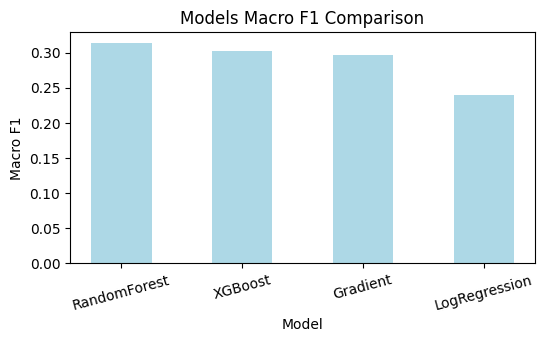

In [86]:
models_comparison(results)

## Feature Importance Analysis

In [65]:
from sklearn.inspection import permutation_importance

In [ ]:
def show_importance(result,):
    p_importances = pd.Series(result.importances_mean)

### Permutation Importance

In [ ]:
pi_rf_result = permutation_importance(rf_model,x_test,y_test,n_repeats=5,random_state=27,n_jobs=2)
pi_xgb_result = permutation_importance(xgb_model,x_test,y_test,n_repeats=5,random_state=27,n_jobs=2)
pi_gradient_result = permutation_importance(gradient_model,x_test,y_test,n_repeats=5,random_state=27,n_jobs=2)

### MDI

## SHAP Analysis

In [58]:
def shap_analyser(model,x_test):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)

    return shap_values

In [59]:
shap_values = shap_analyser(xgb_model,x_test)

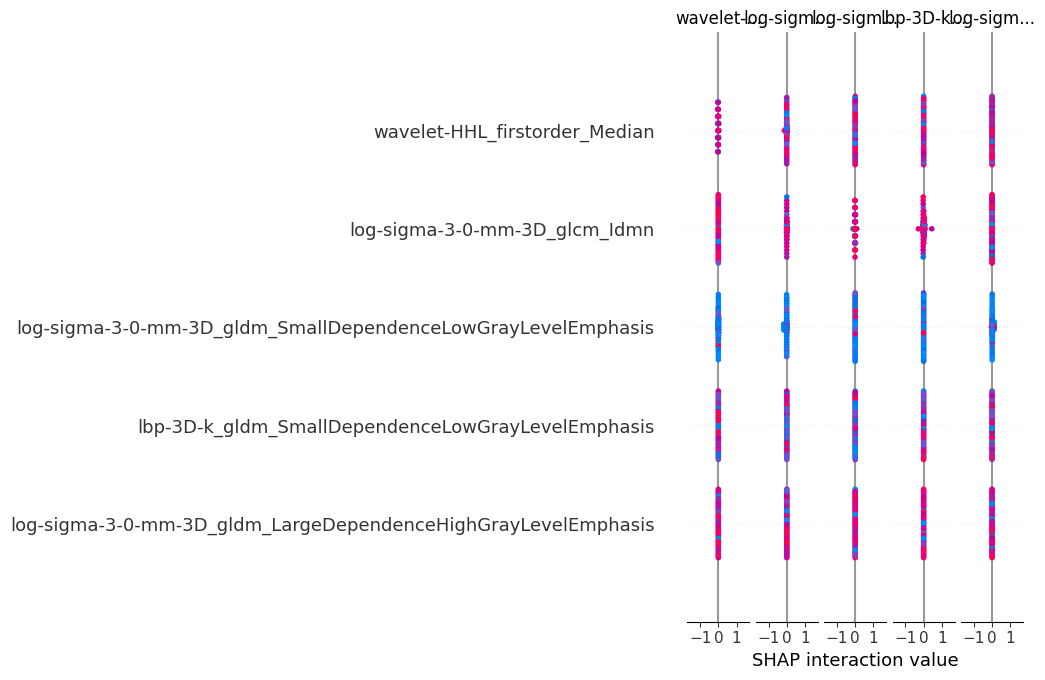

In [60]:
shap.summary_plot(shap_values,x_test)

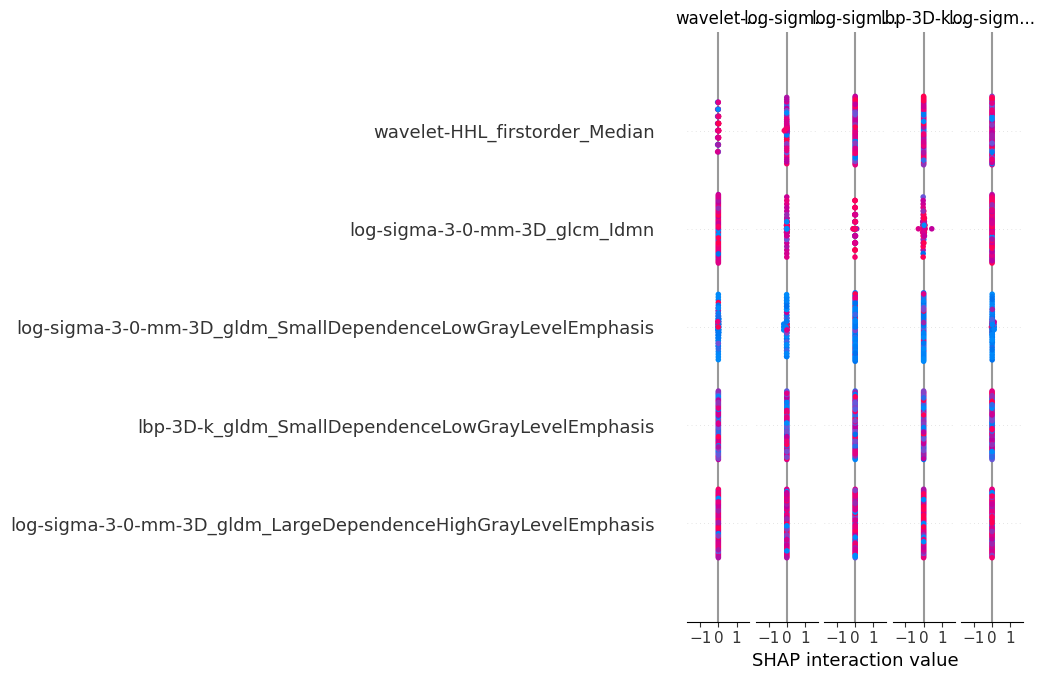

In [61]:
shap.summary_plot(shap_values, x_test, plot_type="bar")

In [62]:
print(len(x_test))
print(len(shap_values))


61
61


ValueError: x and y must be the same size

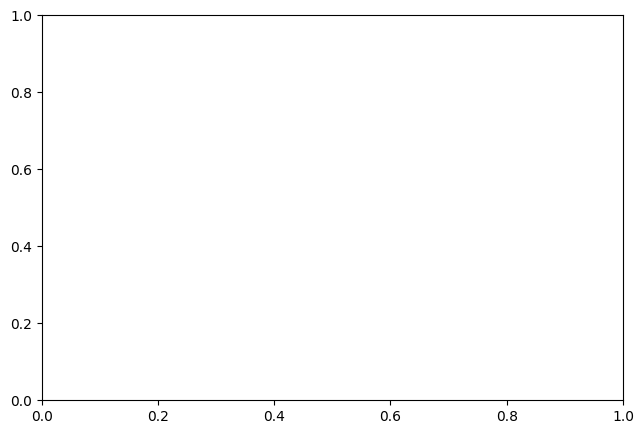

In [63]:
shap.dependence_plot("Sex", shap_values, x_test)
